**Step1** Use Perlin noise to generate map 

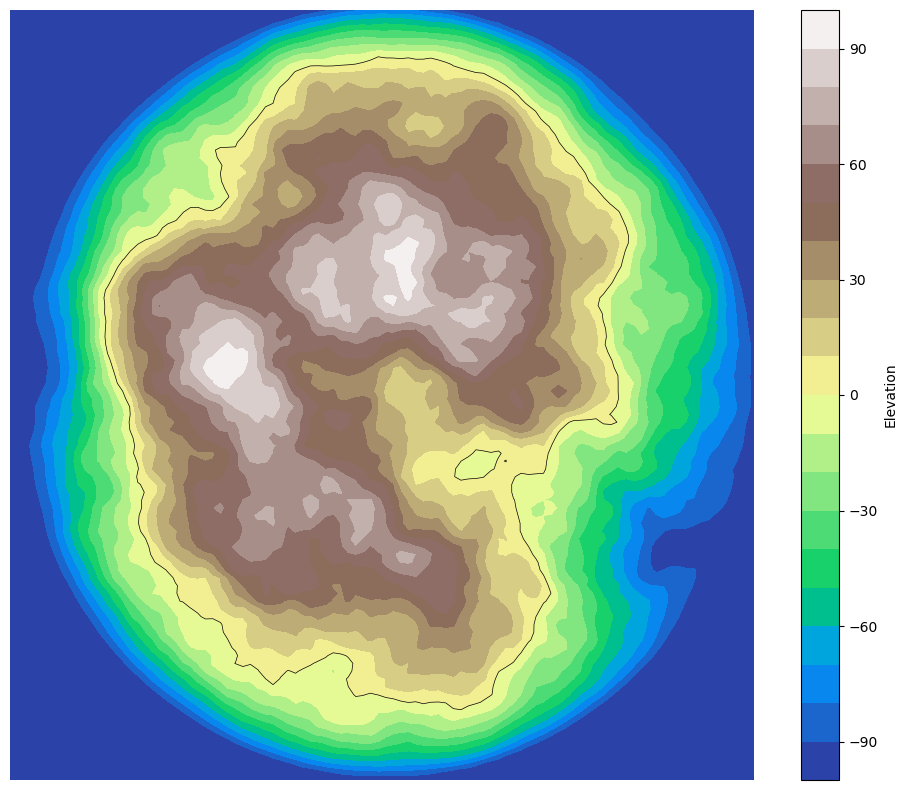

In [5]:
import numpy as np
from noise import pnoise2
import matplotlib.pyplot as plt

# setting the parameters these will generate unique results
size = 100
frequency = 0.28  # Control the frequency of the noise
octaves = 50      # additional octaves for more detail
weight_power = 5 # control the weight of the center

# generate a grid of points
x = np.linspace(0, frequency, size)
y = np.linspace(0, frequency, size)
xv, yv = np.meshgrid(x, y)

# build the Perlin noise
height = np.zeros((size, size))
for i in range(size):
    for j in range(size):
        height[i][j] = pnoise2(xv[i,j], yv[i,j], 
                              octaves=octaves,
                              persistence=0.5,
                              lacunarity=2.0,
                              base=0)

# calculate the center weight
center = (size/2, size/2)
i, j = np.indices((size, size))
dx = (i - center[0])/center[0]  # unify to [-1,1]
dy = (j - center[1])/center[1]
distance = np.sqrt(dx**2 + dy**2)
weight = 1 - np.clip(distance, 0, 1)**weight_power  # central weight

# rescale the height
height *= weight
height = np.interp(height, (height.min(), height.max()), (-100, 100))

# visualize the result for debugging
plt.figure(figsize=(12, 10))
contour = plt.contourf(height, levels=np.linspace(-100, 100, 21), cmap='terrain')
plt.colorbar(contour, label='Elevation')
plt.axis('off')

# display the contour lines
plt.contour(height, levels=[0], colors='black', linewidths=0.5)

plt.show()

**Step2** Convert map to point cloud

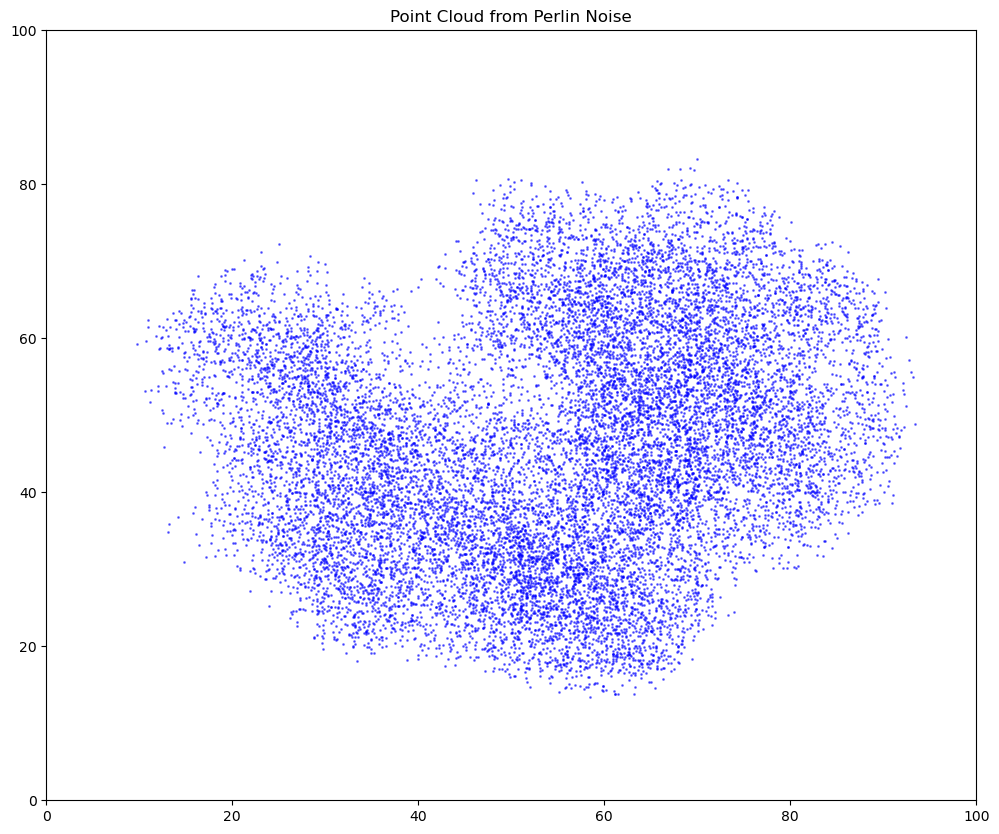

In [6]:
# Convert height to probability (0-100)
height_prob = np.maximum(height, 0)

# Generate point cloud
points = []
density = 10  # Adjust density for more/fewer points

for i in range(size):
    for j in range(size):
        h = height_prob[i, j]
        if h <= 0:
            continue
        prob = h / 100.0
        # Poisson-distributed number of points
        num_points = np.random.poisson(prob * density)
        # Center of the current cell
        x_center, y_center = i + 0.5, j + 0.5
        # Generate points in a circle around the center
        for _ in range(num_points):
            theta = np.random.uniform(0, 2 * np.pi)
            r = np.sqrt(np.random.uniform(0, 1))  # Uniform distribution
            dx = r * np.cos(theta)
            dy = r * np.sin(theta)
            x = x_center + dx
            y = y_center + dy
            # Clip to grid boundaries
            x = np.clip(x, 0, size)
            y = np.clip(y, 0, size)
            points.append((x, y))

points = np.array(points)

# Visualize the point cloud
plt.figure(figsize=(12, 10))
if points.size > 0:
    plt.scatter(points[:, 0], points[:, 1], s=1, color='blue', alpha=0.5)
plt.title('Point Cloud from Perlin Noise')
plt.xlim(0, size)
plt.ylim(0, size)
plt.axis('on')
plt.show()

**Step3** Save data

In [8]:
# export the point cloud to a CSV file
np.savetxt('pointCoordinatesForDemo.csv', 
           points,
           delimiter=',', 
           header='x,y',  # CSV header
           fmt='%f',      # format for floating point numbers
           comments='')   # no comment character